## Disaster warning system


### Task 1


In [35]:
import json
from gdacs.api import GDACSAPIReader
from datetime import datetime, timedelta, timezone
import pandas as pd
from pathlib import Path

client = GDACSAPIReader()
# Define the date range: past two years
end_date = datetime.now(timezone.utc)
start_date = end_date - timedelta(days=730)
# Fetch latest flood events
events = client.latest_events(event_type="FL")
# Access the 'features' list within the GeoJSON response
events_features = events.features

print(f"Number of events {len(events_features)}")

# Make pandas DataFrame from the countries csv
countries_df = pd.read_csv(f"{Path.cwd()}/data/Countries-Europe.csv", usecols=["name"])

# Filter events to only include those in Europe
filtered_events = [
    event
    for event in events_features
    if event["properties"]["country"] in countries_df["name"].values
]

print(f"Number of events in Europe {len(filtered_events)}")

# Filter events to 2 last years
filtered_events = [
    event
    for event in filtered_events
    if start_date
    <= datetime.fromisoformat(filtered_events[0]["properties"]["fromdate"]).replace(
        tzinfo=timezone.utc
    )
    <= end_date
]

print(f"Number of events in Europe in the last 2 years {len(filtered_events)}")

print(f"Filtered events: {json.dumps(filtered_events, indent=2)}")


# Export to CSV
def export_to_csv(events, filename):
    # Create a DataFrame from the events
    df = pd.DataFrame(events)
    # Save to CSV
    df.to_csv(filename, index=False)


export_to_csv(
    filtered_events,
    f"{Path.cwd()}/data/flood_events.csv",
)


Number of events 9
Number of events in Europe 3
Number of events in Europe in the last 2 years 3
Filtered events: [
  {
    "type": "Feature",
    "bbox": [
      0.158666112879269,
      43.1437925,
      0.158666112879269,
      43.1437925
    ],
    "geometry": {
      "type": "Point",
      "coordinates": [
        0.158666112879269,
        43.1437925
      ]
    },
    "properties": {
      "eventtype": "FL",
      "eventid": 1103256,
      "episodeid": 1,
      "eventname": "",
      "glide": "",
      "name": "Flood in France",
      "description": "Flood in France",
      "htmldescription": "Green Flood in France from: 04 May 2025 01 to: 06 May 2025 01.",
      "icon": "https://www.gdacs.org/images/gdacs_icons/maps/Green/FL.png",
      "iconoverall": "https://www.gdacs.org/images/gdacs_icons/maps/Green/FL.png",
      "url": {
        "geometry": "https://www.gdacs.org/gdacsapi/api/polygons/getgeometry?eventtype=FL&eventid=1103256&episodeid=1",
        "report": "https://www.gd

### Task 2


In [36]:
import pandas as pd
from pathlib import Path
import random

# Define the bounding box for Europe (approximate lat/lon ranges)
LAT_MIN, LAT_MAX = 35.0, 70.0
LON_MIN, LON_MAX = -10.0, 40.0
alert_origins = Path.cwd() / "data" / "flood_events.csv"
origins_df = pd.read_csv(alert_origins)

# Define node types and their properties
node_types = [
    {
        "type": "alert_origin",
        "count": 1,
        "role_priority": 5,
        "capacity": 1000,
        "influence_score": 1.0,
    },
    {
        "type": "control_center",
        "count": 10,
        "role_priority": 4,
        "capacity": 500,
        "influence_score": 0.8,
    },
    {
        "type": "media_outlet",
        "count": 20,
        "role_priority": 3,
        "capacity": 200,
        "influence_score": 0.6,
    },
    {
        "type": "community_leader",
        "count": 50,
        "role_priority": 2,
        "capacity": 100,
        "influence_score": 0.4,
    },
    {
        "type": "citizen",
        "count": 100,
        "role_priority": 1,
        "capacity": 10,
        "influence_score": 0.2,
    },
]

# Generate nodes with unique IDs and attributes
nodes = []
csv_id = 1

for _, origin in origins_df.iterrows():
    node_id = 1
    # Parse the geometry field as JSON
    geometry = origin.at["geometry"]
    geometry_dict = json.loads(geometry.replace("'", '"'))
    coordinates = geometry_dict["coordinates"]
    print(f"Alert origin coordinates: {coordinates}")
    node = {
        "node_id": f"Node_{node_id:03d}",
        "node_type": "alert_origin",
        "latitude": coordinates[1],  # Latitude is the second value
        "longitude": coordinates[0],  # Longitude is the first value
        "role_priority": 5,
        "capacity": 1000,
        "influence_score": 1.0,
    }
    nodes.append(node)
    node_id += 1
    for node_type in node_types[1:]:
        for _ in range(node_type["count"]):
            node = {
                "node_id": f"Node_{node_id:03d}",
                "node_type": node_type["type"],
                "latitude": round(random.uniform(LAT_MIN, LAT_MAX), 6),
                "longitude": round(random.uniform(LON_MIN, LON_MAX), 6),
                "role_priority": node_type["role_priority"],
                "capacity": node_type["capacity"],
                "influence_score": node_type["influence_score"],
            }
            nodes.append(node)
            node_id += 1

    # Create a DataFrame and export to CSV
    nodes_df = pd.DataFrame(nodes)
    output_path = Path.cwd() / "data" / f"nodes{csv_id}.csv"
    nodes_df.to_csv(output_path, index=False)
    csv_id += 1
    print(f"Nodes data exported to {output_path}")


Alert origin coordinates: [0.158666112879269, 43.1437925]
Nodes data exported to /home/ozzone/codes/disaster-warning-network/src/data/nodes1.csv
Alert origin coordinates: [7.796819, 45.334155]
Nodes data exported to /home/ozzone/codes/disaster-warning-network/src/data/nodes2.csv
Alert origin coordinates: [21.5575436, 49.28065]
Nodes data exported to /home/ozzone/codes/disaster-warning-network/src/data/nodes3.csv


### Task 3


In [37]:
import pandas as pd
import random
from pathlib import Path
from datetime import datetime, timedelta

node_list = Path.cwd() / "data" / "nodes1.csv"
nodes_df = pd.read_csv(node_list)

PROPAGATION_PATH = [
    "alert_origin",
    "control_center",
    "media_outlet",
    "community_leader",
    "citizen",
]

MESSAGE_TYPES = ["SMS", "App Notification"]
DELAY_MIN, DELAY_MAX = 10, 180  # Seconds
RELIABILITY_MIN, RELIABILITY_MAX = 0, 1

message_records = []
alert_time = datetime.now()


# From message records, get the sent timestamp of a node
def get_timestamp_sent(node_id):
    for message in message_records:
        if message["source_node_id"] == node_id:
            return datetime.fromisoformat(message["timestamp_sent"])
    return alert_time


# Randomly generate connections between all nodes
for i in range(len(PROPAGATION_PATH) - 1):
    source_nodes = nodes_df[nodes_df["node_type"] == PROPAGATION_PATH[i]]
    target_nodes = nodes_df[nodes_df["node_type"] == PROPAGATION_PATH[i + 1]]
    time_sent = alert_time
    for _, target in target_nodes.iterrows():
        random_node = source_nodes.sample(1).iloc[0]
        processing_delay = random.randint(DELAY_MIN, DELAY_MAX // 3)
        time_sent = get_timestamp_sent(random_node["node_id"]) + timedelta(
            seconds=processing_delay
        )
        transmission_delay = random.randint(DELAY_MIN, DELAY_MAX)
        time_received = time_sent + timedelta(seconds=transmission_delay)
        message_records.append(
            {
                "source_node_id": random_node["node_id"],
                "destination_node_id": target["node_id"],
                "message_type": random.choice(MESSAGE_TYPES),
                "timestamp_sent": time_sent.isoformat(),
                "timestamp_received": time_received.isoformat(),
                "delay_in_seconds": transmission_delay,
                "reliability_score": round(
                    random.uniform(RELIABILITY_MIN, RELIABILITY_MAX), 2
                ),
            }
        )

# Randomly generate at least 300 message records
while len(message_records) < 300:
    path_nodes = []
    for node_type in PROPAGATION_PATH:
        type_nodes = nodes_df[nodes_df["node_type"] == node_type]
        random_node = type_nodes.sample(1).iloc[0]
        path_nodes.append(random_node)
    time_sent = alert_time
    for i in range(len(path_nodes) - 1):
        transmission_delay = random.randint(DELAY_MIN, DELAY_MAX)
        time_received = time_sent + timedelta(seconds=transmission_delay)
        message_records.append(
            {
                "source_node_id": path_nodes[i]["node_id"],
                "destination_node_id": path_nodes[i + 1]["node_id"],
                "message_type": random.choice(MESSAGE_TYPES),
                "timestamp_sent": time_sent.isoformat(),
                "timestamp_received": time_received.isoformat(),
                "delay_in_seconds": transmission_delay,
                "reliability_score": round(
                    random.uniform(RELIABILITY_MIN, RELIABILITY_MAX), 2
                ),
            }
        )
        # Delay to not send the received message immediately
        processing_delay = random.randint(DELAY_MIN, DELAY_MAX // 3)
        time_sent = time_received + timedelta(seconds=processing_delay)

messages_df = pd.DataFrame(message_records)
output_path = Path.cwd() / "data" / "message_records.csv"
messages_df.to_csv(output_path, index=False)

print(f"Synthetic alert diffusion dataset exported to {output_path}")


Synthetic alert diffusion dataset exported to /home/ozzone/codes/disaster-warning-network/src/data/message_records.csv


### Task 4


In [38]:
import pandas as pd
import networkx as nx
from pathlib import Path

nodes_path = Path.cwd() / "data" / "nodes1.csv"
messages_path = Path.cwd() / "data" / "message_records.csv"
nodes_df = pd.read_csv(nodes_path)
messages_df = pd.read_csv(messages_path)

# Construct a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for _, row in nodes_df.iterrows():
    node = row["node_id"]
    G.add_node(node)
    G.nodes[node]["node_type"] = row["node_type"]
    G.nodes[node]["latitude"] = row["latitude"]
    G.nodes[node]["longitude"] = row["longitude"]
    G.nodes[node]["role_priority"] = row["role_priority"]
    G.nodes[node]["capacity"] = row["capacity"]
    G.nodes[node]["influence_score"] = row["influence_score"]

# Assing relevant edge attributes from grouped messages
messages_group = messages_df.groupby(["source_node_id", "destination_node_id"])
for message in messages_group:
    src = message[0][0]
    tgt = message[0][1]
    avg_delay = round(float(message[1]["delay_in_seconds"].mean()), 2)
    avg_reliability = round(float(message[1]["reliability_score"].mean()), 2)
    message_count = int(message[1]["message_type"].count())
    G.add_edge(
        src, tgt, delay=avg_delay, reliability=avg_reliability, messages=message_count
    )

# Graph direction and connection validation
print(f"Graph is directed: {nx.is_directed(G)}")
print(f"Graph is connected: {nx.is_weakly_connected(G)}")

# Export the graph
graph_path = Path.cwd() / "data" / "communication.graphml"
nx.write_graphml(G, graph_path)
print(f"Graph exported to {graph_path}")


Graph is directed: True
Graph is connected: True
Graph exported to /home/ozzone/codes/disaster-warning-network/src/data/communication.graphml


### Task 5


In [39]:
import networkx as nx
from pathlib import Path

graph_path = Path.cwd() / "data" / "communication.graphml"
output_path = Path.cwd() / "data" / "communication_updated.graphml"

G = nx.read_graphml(graph_path)

delay_values = list(nx.get_edge_attributes(G, "delay").values())
reliability_values = list(nx.get_edge_attributes(G, "reliability").values())

delay_min, delay_max = min(delay_values), max(delay_values)
reliability_min, reliability_max = min(reliability_values), max(reliability_values)

# Calculate and assign weights and normalized values to edges
for edge in G.edges(data=True):
    src = edge[0]
    tgt = edge[1]
    delay = edge[2]["delay"]
    reliability = edge[2]["reliability"]
    weight = round(delay / (reliability + 1e-6), 2)  # Avoid division by zero
    delay_normalized = round((delay - delay_min) / (delay_max - delay_min), 2)
    reliability_normalized = round(
        (reliability - reliability_min) / (reliability_max - reliability_min), 2
    )
    G.edges[src, tgt]["weight"] = weight
    G.edges[src, tgt]["delay_normalized"] = delay_normalized
    G.edges[src, tgt]["reliability_normalized"] = reliability_normalized

nx.write_graphml(G, output_path)

print("Calculated values stored as edge attributes.")


Calculated values stored as edge attributes.


### Task 6 & 7


Loading Graph from /home/ozzone/codes/disaster-warning-network/src/data/communication_updated.graphml
Graph loaded: 181 nodes, 265 edges

Simulation finished. Processed 61 potential events.
31 out of 181 nodes activated.


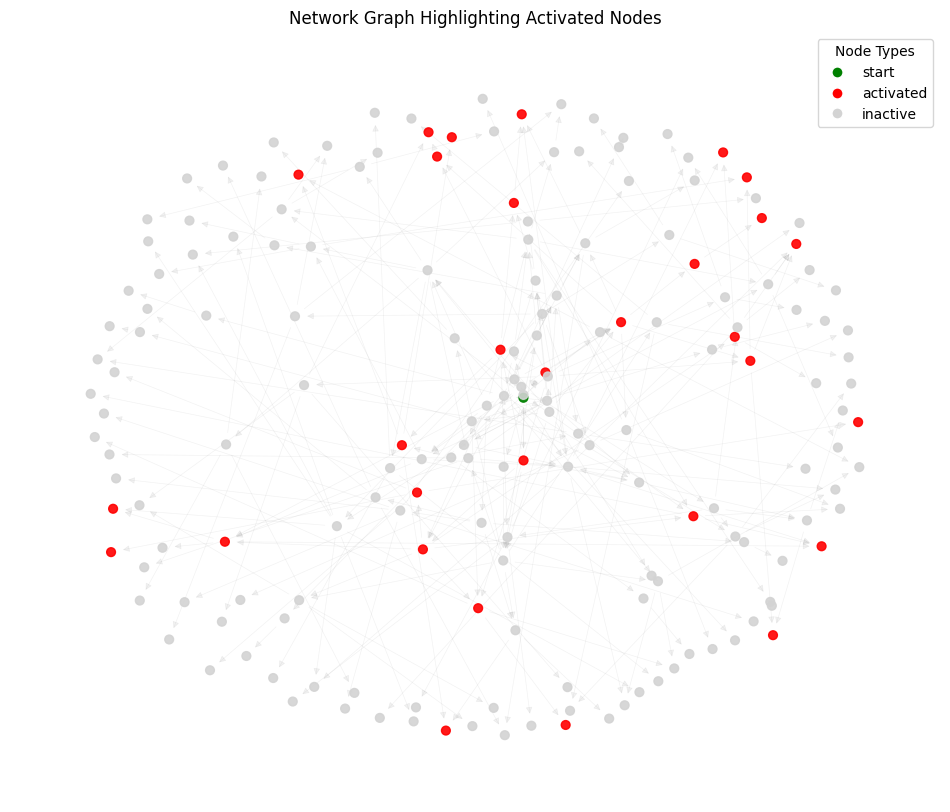

Alert Reach: 17.13%
Max Activation Time (Simulation Duration): 524.00 seconds
Average Activation Time (among activated): 316.90 seconds

Propagation delay for each group:
          node_type  Average delay (s)  Minimum delay (s)  Maximum delay (s)  \
0      alert_origin           0.000000               0.00               0.00   
1           citizen         391.166667             276.00             524.00   
2  community_leader         311.475000             241.25             388.25   
3    control_center         100.125000              67.25             133.00   
4      media_outlet         213.833333             203.00             229.25   

   Nodes activated  
0                1  
1               15  
2               10  
3                2  
4                3  


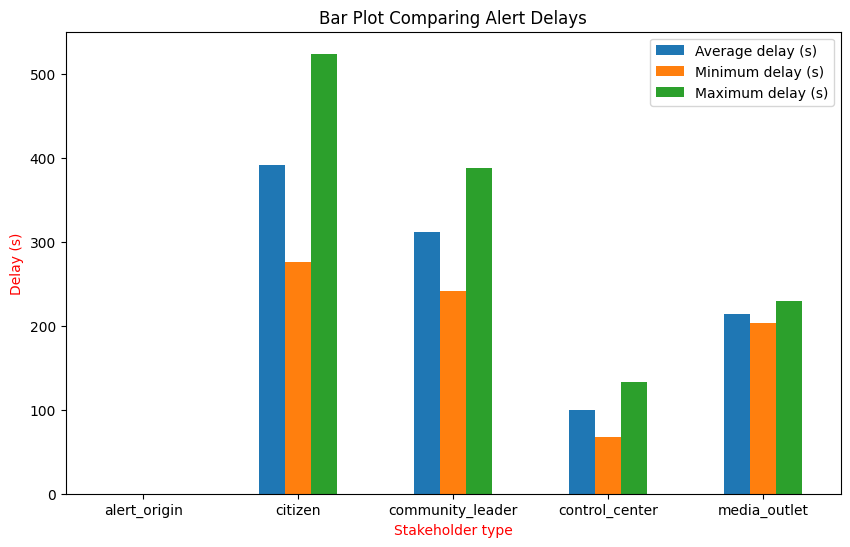

In [40]:
import networkx as nx
from pathlib import Path
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# TASK 6
# The propagation model selected for this task is Independent Cascade (IC)

# Get graph file from data
GRAPH_FILE = Path.cwd() / "data" / "communication_updated.graphml"

# Load graph
print(f"Loading Graph from {GRAPH_FILE}")
G = nx.read_graphml(GRAPH_FILE)
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Save alert_origin node to variable, set up activation_times to track nodes and times and event_queue to keep track of events remaining
start_node = "Node_001"
activation_times = {start_node: 0.0}
event_queue = []

# Initialize event list with attempts from the start node
for neighbor in G.successors(start_node):
    edge_data = G.get_edge_data(start_node, neighbor)
    delay = float(edge_data.get("delay"))

    # Add event to queue
    event_queue.append((0.0 + delay, neighbor, start_node))

processed_events = 0
# Loop while events in queue
while event_queue:
    processed_events += 1
    # Sort event queue by time in each iteration
    event_queue.sort()
    # Get and remove the earliest event from queue
    activation_attempt_time, target_node, source_node = event_queue.pop(0)

    # Check if activation is a success based on reliability
    edge_data = G.get_edge_data(source_node, target_node)
    realiability = float(edge_data.get("reliability"))

    if random.random() <= realiability:
        # Activation successful
        activation_times[target_node] = activation_attempt_time

        # Schedule activation attempts for its neighbors
        for neighbor in G.successors(target_node):
            # Only schedule unactivated neighbors
            if neighbor not in activation_times:
                neighbor_edge_data = G.get_edge_data(target_node, neighbor)
                delay = float(neighbor_edge_data.get("delay"))

                # Time when neighbor will receive the message
                neighbor_activation_time = activation_attempt_time + delay
                # Append new event to event queue
                event_queue.append((neighbor_activation_time, neighbor, target_node))

print(f"\nSimulation finished. Processed {processed_events} potential events.")
print(f"{len(activation_times)} out of {G.number_of_nodes()} nodes activated.")

# Visualize results

plt.figure(figsize=(12, 10))
# Determine simple node colors
node_colors = []
color_map = {"start": "green", "activated": "red", "inactive": "lightgrey"}
for node in G.nodes():
    if node == start_node:
        node_colors.append(color_map["start"])
    elif node in activation_times:
        node_colors.append(color_map["activated"])
    else:
        node_colors.append(color_map["inactive"])

# Draw the graph with simple colors and uniform node size
nx.draw_networkx_edges(
    G, pos=nx.spring_layout(G, seed=42), alpha=0.1, edge_color="gray", width=0.5
)
nx.draw_networkx_nodes(
    G, pos=nx.spring_layout(G, seed=42), node_color=node_colors, node_size=40, alpha=0.9
)

# Add legend
legend_handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", label=t, markersize=8, markerfacecolor=c
    )
    for t, c in color_map.items()
]
legend1 = plt.legend(
    handles=legend_handles,
    title="Node Types",
    loc="upper right",
    bbox_to_anchor=(1.0, 1.0),
)

# Add title
plt.title("Network Graph Highlighting Activated Nodes")
plt.axis("off")
plt.show()

# Analyze results

# Extract times for analysis
times_list = list(activation_times.values())
max_time = np.max(times_list)
avg_time = np.mean(times_list)
reach_fraction = len(activation_times) / G.number_of_nodes()

print(f"Alert Reach: {reach_fraction:.2%}")
print(f"Max Activation Time (Simulation Duration): {max_time:.2f} seconds")
print(f"Average Activation Time (among activated): {avg_time:.2f} seconds")


# TASK 7
# Create pandas dataframe from activation_times
timestamp_records = []
for node, time in activation_times.items():
    timestamp_records.append({"node_id": node, "activation_time": time})

timestamps_df = pd.DataFrame(timestamp_records)

# Add node type information from the graph
node_type_map = nx.get_node_attributes(G, "node_type")
timestamps_df["node_type"] = (
    timestamps_df["node_id"].map(node_type_map).fillna("Unknown")
)

# Calculate delay (GDACS alert origin is 0.0 => no subtraction needed)
timestamps_df["delay"] = timestamps_df["activation_time"]

# Group nodes by type, calculate average, minimum and maximum delays and rename columns
delay_stats_df = (
    timestamps_df.groupby("node_type")["delay"]
    .agg(["mean", "min", "max", "count"])
    .reset_index()
)
delay_stats_df = delay_stats_df.rename(
    columns={
        "mean": "Average delay (s)",
        "min": "Minimum delay (s)",
        "max": "Maximum delay (s)",
        "count": "Nodes activated",
    }
)

print("\nPropagation delay for each group:")
print(delay_stats_df)

# Visualize results
fig, ax = plt.subplots(figsize=(10, 6))

# Create indexes for bar plot
plot_data = delay_stats_df.set_index("node_type")[
    ["Average delay (s)", "Minimum delay (s)", "Maximum delay (s)"]
]

# Create bar plot and add labels
plot_data.plot(kind="bar", ax=ax)
ax.set_xlabel("Stakeholder type", color="red")
ax.set_ylabel("Delay (s)", color="red")
ax.tick_params(axis="x", rotation=0)

# Add title
plt.title("Bar Plot Comparing Alert Delays")
plt.show()

# Save results
output_path = Path.cwd() / "data" / "timestamps_delay.csv"
timestamps_df.to_csv(output_path, index=False)


### Task 8


Loading Graph from /home/ozzone/codes/disaster-warning-network/src/data/communication_updated.graphml
Graph loaded: 181 nodes, 265 edges

Delay threshold: 355.65s
12 nodes found with high delay

Centrality threshold: 0.0005896958410924892
34 nodes found with high centrality.

1 potential bottleneck nodes found.
['Node_044']


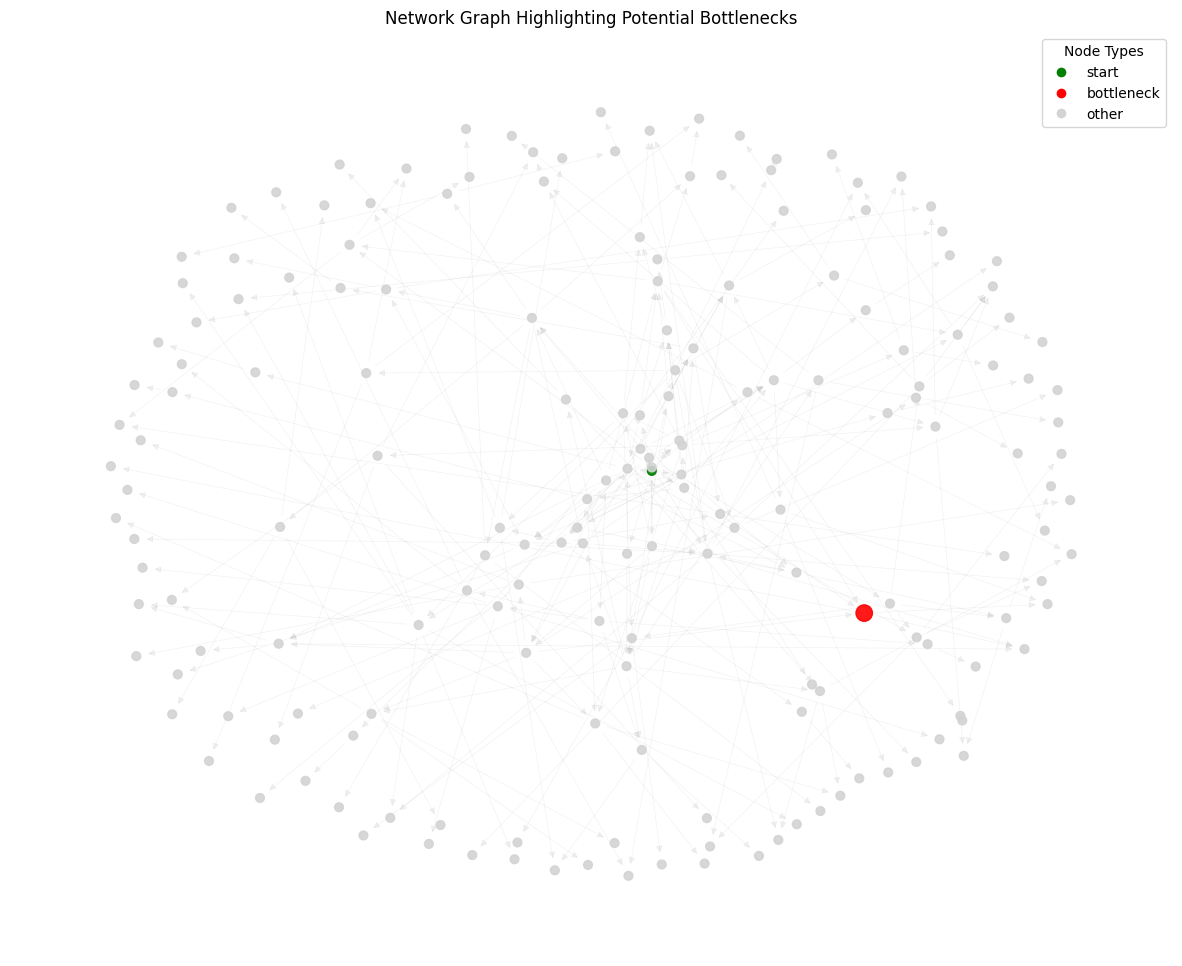

In [41]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Get graph file from data
GRAPH_FILE = Path.cwd() / "data" / "communication_updated.graphml"

# Load graph
print(f"Loading Graph from {GRAPH_FILE}")
G = nx.read_graphml(GRAPH_FILE)
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Load timestamps data
timestamps_list = Path.cwd() / "data" / "timestamps_delay.csv"
timestamps_df = pd.read_csv(timestamps_list)

# Exclude alert origin (delay 0.0) from calculations
valid_delays = timestamps_df[timestamps_df["delay"] > 0.0]["delay"]

# Set high delay threshold as 60% and create a set of high delay nodes with that threshold
high_delay_threshold = np.percentile(valid_delays, 60)
high_delay_nodes = set(
    timestamps_df[timestamps_df["delay"] >= high_delay_threshold]["node_id"]
)

print(f"\nDelay threshold: {high_delay_threshold}s")
print(f"{len(high_delay_nodes)} nodes found with high delay")

# Calculate betweenness centrality for each node weighted by delay
betweenness_centrality = nx.betweenness_centrality(G, weight="delay")

# Identify nodes with high betweenness centrality
# Filter out zero centrality values
centrality_values = np.array([c for c in betweenness_centrality.values() if c > 0.0])

# Set high centrality threshold as 60% and create an array of high centrality nodes with that threshold
high_centrality_threshold = np.percentile(centrality_values, 60)
high_centrality_nodes = {
    node
    for node, centrality in betweenness_centrality.items()
    if centrality >= high_centrality_threshold and centrality > 0
}

print(f"\nCentrality threshold: {high_centrality_threshold}")
print(f"{len(high_centrality_nodes)} nodes found with high centrality.")

# Find bottlenecks (nodes with high delay and high centrality)
bottlenecks = list(high_delay_nodes.intersection(high_centrality_nodes))

# Exclude start node (Node_001) from being a bottleneck
bottlenecks = [node for node in bottlenecks if node != "Node_001"]

if bottlenecks:
    print(f"\n{len(bottlenecks)} potential bottleneck nodes found.")
    print(bottlenecks)
else:
    print("No bottleneck nodes found")

# Visualize results
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=42)

node_colors = []
node_sizes = []
color_map = {"start": "green", "bottleneck": "red", "other": "lightgrey"}
for node in G.nodes():
    if node == "Node_001":
        node_colors.append(color_map["start"])
        node_sizes.append(40)
    elif node in bottlenecks:
        node_colors.append(color_map["bottleneck"])
        node_sizes.append(140)
    else:
        node_colors.append(color_map["other"])
        node_sizes.append(40)

nx.draw_networkx_edges(
    G, pos=nx.spring_layout(G, seed=42), alpha=0.1, edge_color="gray", width=0.5
)
nx.draw_networkx_nodes(
    G,
    pos=nx.spring_layout(G, seed=42),
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.9,
)

# Add legend
legend_handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", label=t, markersize=8, markerfacecolor=c
    )
    for t, c in color_map.items()
]
legend1 = plt.legend(
    handles=legend_handles,
    title="Node Types",
    loc="upper right",
    bbox_to_anchor=(1.0, 1.0),
)

# Add title
plt.title("Network Graph Highlighting Potential Bottlenecks")
plt.axis("off")
plt.show()

# Discussion about bottlenecks

# The identified potential bottlenecks are critical since they are central to many communication paths because of high centrality.
# These bottlenecks also tend to receive the alert relatively late compared to others since they have high delay.
# High delays at these nodes can slow down the alert dissemination to large parts of the network that depend on them.
# Removing these bottlenecks should not be considered. As stated earlier, these are central to may communication paths due to high centrality.
# It could cause more harm if they were removed. Replacing these nodes by creating alternative links that bypass these bottlenecks would be a better option.
# Other options to fix bottlenecks:
# - if delay is internal, improve processing capacity/speed
# - reconfigure tasks performed by a bottleneck node to less central nodes if possible


### Task 9


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import folium
from pathlib import Path

# Load node dataset into pandas dataframe
nodes_path = Path.cwd() / "data" / "nodes1.csv"
nodes_df = pd.read_csv(nodes_path)

# Load graph
graph_path = Path.cwd() / "data" / "communication_updated.graphml"
G = nx.read_graphml(graph_path)

# Ensure that latitude and longitude fields are correctly formatted
nodes_df["latitude"] = nodes_df["latitude"].astype(float)
nodes_df["longitude"] = nodes_df["longitude"].astype(float)

# Centrality values
betweenness_centrality = nx.betweenness_centrality(G, weight="delay")
centrality_values = np.array([c for c in betweenness_centrality.values()])

# Normalize centrality values
min_centrality, max_centrality = min(centrality_values), max(centrality_values)
centralities_normalized = np.array(
    [
        round((c - min_centrality) / (max_centrality - min_centrality), 2)
        for c in centrality_values
    ]
)

# Create a folium map located at the average latitude and longitude of the nodes
m = folium.Map(location=[nodes_df["latitude"].mean(), nodes_df["longitude"].mean()])

# Customized colors based on node type
customized_colors = {
    "alert_origin": "red",
    "control_center": "orange",
    "media_outlet": "blue",
    "community_leader": "green",
    "citizen": "gray",
}

# Add circle markers for each node sized by centrality value and colored by node type
for i, row in nodes_df.iterrows():
    node_id = row["node_id"]
    node_type = row["node_type"]
    centrality = centralities_normalized[i]
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=5 + (centrality * 20),
        color=customized_colors.get(node_type),
        fill=True,
        fill_color=customized_colors.get(node_type),
        fill_opacity=0.7,
        popup=f"ID:{node_id} Type:{node_type} Centrality:{centrality}",
    ).add_to(m)

output_path = Path.cwd() / "data" / "interactive_map.html"
m.save(output_path)
print(f"Map exported to {output_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/home/ozzone/codes/disaster-warning-network/src/data/nodes.csv'

### Task 10


Loading Graph from /home/ozzone/codes/disaster-warning-network/src/data/communication_updated.graphml
Graph loaded: 181 nodes, 265 edges

4 critical nodes found (Top 15 in >= 3 measures):
                 node_type  top_n_count  degree_rank  closeness_rank  \
Node_012      media_outlet            3          8.0            14.0   
Node_016      media_outlet            3          1.0             9.0   
Node_033  community_leader            3          6.0             1.0   
Node_059  community_leader            3         11.0             8.0   

          betweenness_rank  eigenvector_rank  
Node_012               5.0             151.0  
Node_016               1.0             158.0  
Node_033               7.0             107.0  
Node_059               9.0             120.0  


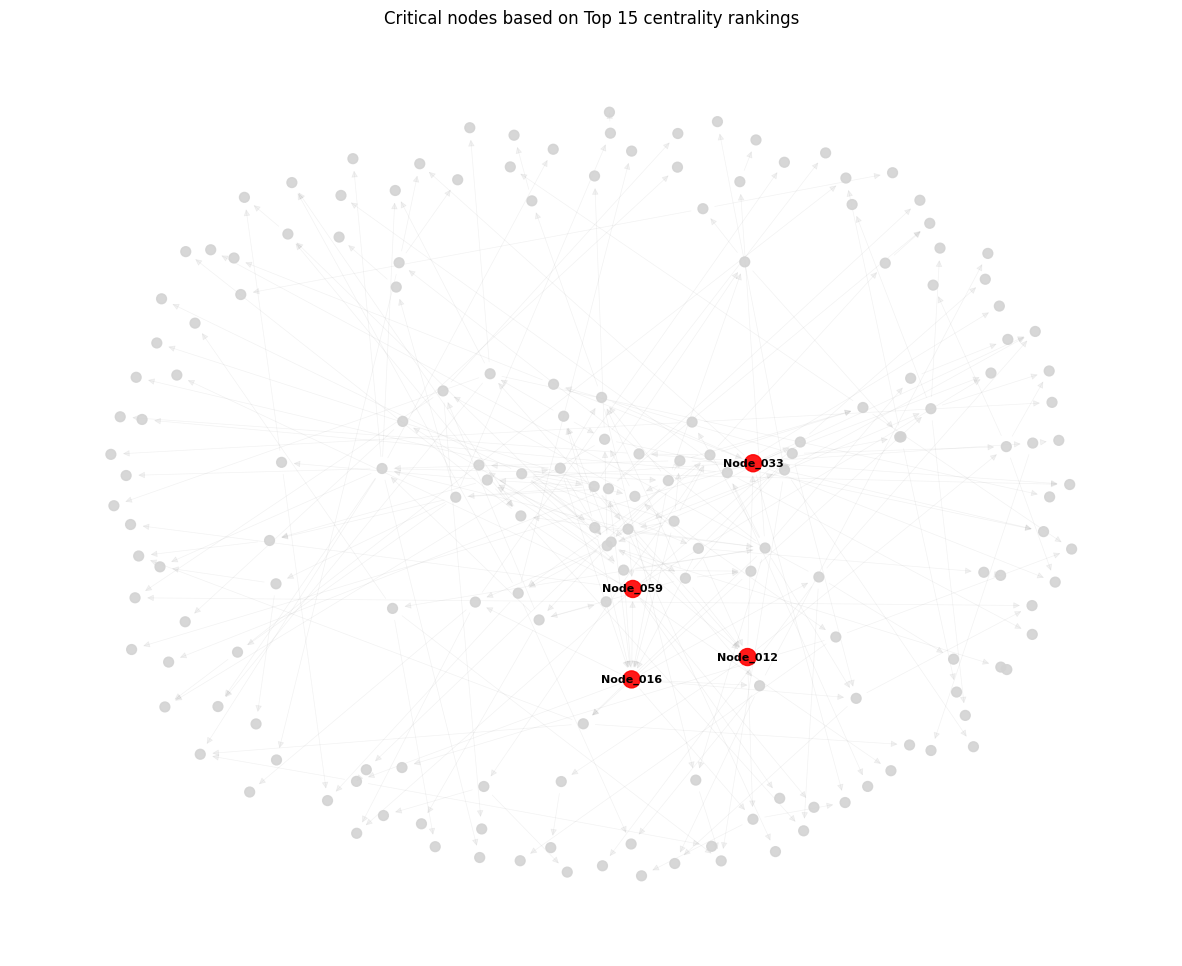

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Get graph file from data
GRAPH_FILE = Path.cwd() / "data" / "communication_updated.graphml"

# Load graph
print(f"Loading Graph from {GRAPH_FILE}")
G = nx.read_graphml(GRAPH_FILE)
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Calculate centrality scores
centrality_scores = {}

# Degree centrality
centrality_scores["degree"] = nx.degree_centrality(G)

# Closeness centrality, use delay as distance
centrality_scores["closeness"] = nx.closeness_centrality(G, distance="delay")

# Betweenness centrality, use delay as weight
centrality_scores["betweenness"] = nx.betweenness_centrality(
    G, weight="delay", normalized=True
)

# Eigenvector centrality, use "weight" calculated in task 5 as weight
centrality_scores["eigenvector"] = nx.eigenvector_centrality(
    G, weight="weight", max_iter=500
)

# Combine results into DataFrame

# Create DataFrame with degree centrality
centrality_df = pd.DataFrame.from_dict(
    centrality_scores["degree"], orient="index", columns=["degree"]
)

# Add other centralities with for loop
for name, scores_dict in centrality_scores.items():
    if name != "degree":
        centrality_df[name] = pd.Series(scores_dict)

# Add node type from graph attributes
node_type_map = nx.get_node_attributes(G, "node_type")
centrality_df["node_type"] = centrality_df.index.map(node_type_map)

# Rank nodes
rank_cols = []
for col in centrality_scores.keys():
    if col in centrality_df.columns:
        rank_col = f"{col}_rank"
        centrality_df[rank_col] = centrality_df[col].rank(ascending=False, method="min")
        rank_cols.append(rank_col)

# Identify constantly high-ranked nodes
# Set up parameters for analysis
TOP_N_RANK = 15  # How many top nodes per centrality to consider
MIN_CENTRALITY_COUNT = 3  # Node must be in top 15 for at least in 3 centralities

is_top_n = centrality_df[rank_cols] <= TOP_N_RANK
centrality_df["top_n_count"] = is_top_n.sum(axis=1)

critical_nodes_df = centrality_df[
    centrality_df["top_n_count"] >= MIN_CENTRALITY_COUNT
].sort_values("top_n_count", ascending=False)
critical_nodes_list = critical_nodes_df.index.tolist()

print(
    f"\n{len(critical_nodes_list)} critical nodes found (Top {TOP_N_RANK} in >= {MIN_CENTRALITY_COUNT} measures):"
)
print(critical_nodes_df[["node_type", "top_n_count"] + rank_cols])

# Visualize results
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=42)

# Change size and color for critical nodes
node_sizes = []
node_colors = []
for node in G.nodes():
    if node in critical_nodes_list:
        node_sizes.append(150)
        node_colors.append("red")
    else:
        node_sizes.append(50)
        node_colors.append("lightgrey")

nx.draw_networkx_edges(G, pos=pos, alpha=0.1, edge_color="gray", width=0.5)
nx.draw_networkx_nodes(
    G, pos=pos, node_color=node_colors, node_size=node_sizes, alpha=0.9
)

# Add labels for critical nodes
labels = {}
for node in critical_nodes_list:
    labels[node] = node

nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=8, font_weight="bold")

# Add title
plt.title("Critical nodes based on Top 15 centrality rankings")
plt.axis("off")
plt.show()

# Discussion

# Nodes ranked high in betweenness centrality are crucial bridges, information between different network parts likely flow through them.
# Nodes ranked high in degree or eigenvector centrality potentially reach many other nodes. Their messages might spread widely.
# Nodes ranked high in closeness centrality (low average delay) can access information relatively quickly.
# Nodes ranked high in multiple centralities represent significant points of dependency. In this analysis both nodes are community leaders.
# If these important nodes fail during a disaster, consequences can be disturbing.
#   - For example, information could be significantly slowed down or network might split into disconnected components.
# How to improve: Network design should consider redundancy for critical nodes/pathways to reduce reliance .cwd()